<a href="https://colab.research.google.com/github/yogapriya-28/Amazon-Music-Clustering-/blob/main/coffee_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#**Data preprocessing**

In [2]:
# Load the dataset
df = pd.read_csv('/content/Coffe_sales.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  3547 non-null   int64  
 1   cash_type    3547 non-null   object 
 2   money        3547 non-null   float64
 3   coffee_name  3547 non-null   object 
 4   Time_of_Day  3547 non-null   object 
 5   Weekday      3547 non-null   object 
 6   Month_name   3547 non-null   object 
 7   Weekdaysort  3547 non-null   int64  
 8   Monthsort    3547 non-null   int64  
 9   Date         3547 non-null   object 
 10  Time         3547 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


In [4]:
df.shape

(3547, 11)

In [5]:
df.describe()

,hour_of_day,money,Weekdaysort,Monthsort
count,3547.000000,3547.000000,3547.000000,3547.000000
mean,14.185791,31.645216,3.845785,6.453905
std,4.234010,4.877754,1.971501,3.500754
min,6.000000,18.120000,1.000000,1.000000
25%,10.000000,27.920000,2.000000,3.000000
50%,14.000000,32.820000,4.000000,7.000000
75%,18.000000,35.760000,6.000000,10.000000
max,22.000000,38.700000,7.000000,12.000000


In [6]:
df.isnull().sum()

,0
hour_of_day,0
cash_type,0
money,0
coffee_name,0
Time_of_Day,0
Weekday,0
Month_name,0
Weekdaysort,0
Monthsort,0
Date,0


In [7]:
# Convert DateTime to datetime type
df['DateTime'] = pd.to_datetime(df['Date'])

# Create additional features
df['Date'] = df['DateTime'].dt.date
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['DayOfMonth'] = df['DateTime'].dt.day
df['Week'] = df['DateTime'].dt.isocalendar().week

print(f"Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")
print(f"Total transactions: {len(df)}")
print(f"Total unique days: {df['Date'].nunique()}")

Date range: 2024-03-01 00:00:00 to 2025-03-23 00:00:00
Total transactions: 3547
Total unique days: 381


#**Feature Engineering - distributions calculation**

In this code set, we transform a dataset to an aggregated format, and then calculate distributions of sales by time of day and by coffee type.

In [8]:
# Aggregate data by day
daily_data = df.groupby('Date').agg({
    'money': 'sum',  # Total daily sales
    'DateTime': 'count',  # Number of transactions
    'Weekday': 'first',
    'Weekdaysort': 'first',
    'Month_name': 'first',
    'Monthsort': 'first'
}).rename(columns={'DateTime': 'num_transactions'})

# Add time-of-day distribution (proportion of orders)
time_dist = df.groupby(['Date', 'Time_of_Day']).size().unstack(fill_value=0)
time_dist_pct = time_dist.div(time_dist.sum(axis=1), axis=0)
time_dist_pct.columns = [f'pct_{col.lower()}' for col in time_dist_pct.columns]

# Add coffee type distribution (proportion of orders)
coffee_dist = df.groupby(['Date', 'coffee_name']).size().unstack(fill_value=0)
coffee_dist_pct = coffee_dist.div(coffee_dist.sum(axis=1), axis=0)
coffee_dist_pct.columns = [f'pct_{col.lower().replace(" ", "_")}' for col in coffee_dist_pct.columns]

# Add payment type distribution
payment_dist = df.groupby(['Date', 'cash_type']).size().unstack(fill_value=0)
payment_dist_pct = payment_dist.div(payment_dist.sum(axis=1), axis=0)
payment_dist_pct.columns = [f'pct_{col.lower()}' for col in payment_dist_pct.columns]

# Merge all features
daily_data = daily_data.join([time_dist_pct, coffee_dist_pct, payment_dist_pct])

# Add average transaction value
daily_data['avg_transaction'] = daily_data['money'] / daily_data['num_transactions']

# Add rolling averages (7-day window)
daily_data['sales_7day_avg'] = daily_data['money'].rolling(window=7, min_periods=1).mean()
daily_data['transactions_7day_avg'] = daily_data['num_transactions'].rolling(window=7, min_periods=1).mean()

# Add day-of-week averages (historical)
weekday_avg = daily_data.groupby('Weekdaysort')['money'].expanding().mean().reset_index(level=0, drop=True)
daily_data['weekday_historical_avg'] = weekday_avg

print(f"Daily dataset shape: {daily_data.shape}")
print(f"\nFeatures created:")
print(daily_data.columns.tolist())
print(f"\nSample of daily data:")
print(daily_data.head())

Daily dataset shape: (381, 22)

Features created:
['money', 'num_transactions', 'Weekday', 'Weekdaysort', 'Month_name', 'Monthsort', 'pct_afternoon', 'pct_morning', 'pct_night', 'pct_americano', 'pct_americano_with_milk', 'pct_cappuccino', 'pct_cocoa', 'pct_cortado', 'pct_espresso', 'pct_hot_chocolate', 'pct_latte', 'pct_card', 'avg_transaction', 'sales_7day_avg', 'transactions_7day_avg', 'weekday_historical_avg']

Sample of daily data:
            money  num_transactions Weekday  Weekdaysort Month_name  \
Date                                                                  
2024-03-01  396.3                11     Fri            5        Mar   
2024-03-02  188.1                 6     Sat            6        Mar   
2024-03-03  309.1                 9     Sun            7        Mar   
2024-03-04  135.2                 4     Mon            1        Mar   
2024-03-05  338.5                 9     Tue            2        Mar   

            Monthsort  pct_afternoon  pct_morning  pct_night 

#**Exploratory Data Analysis**

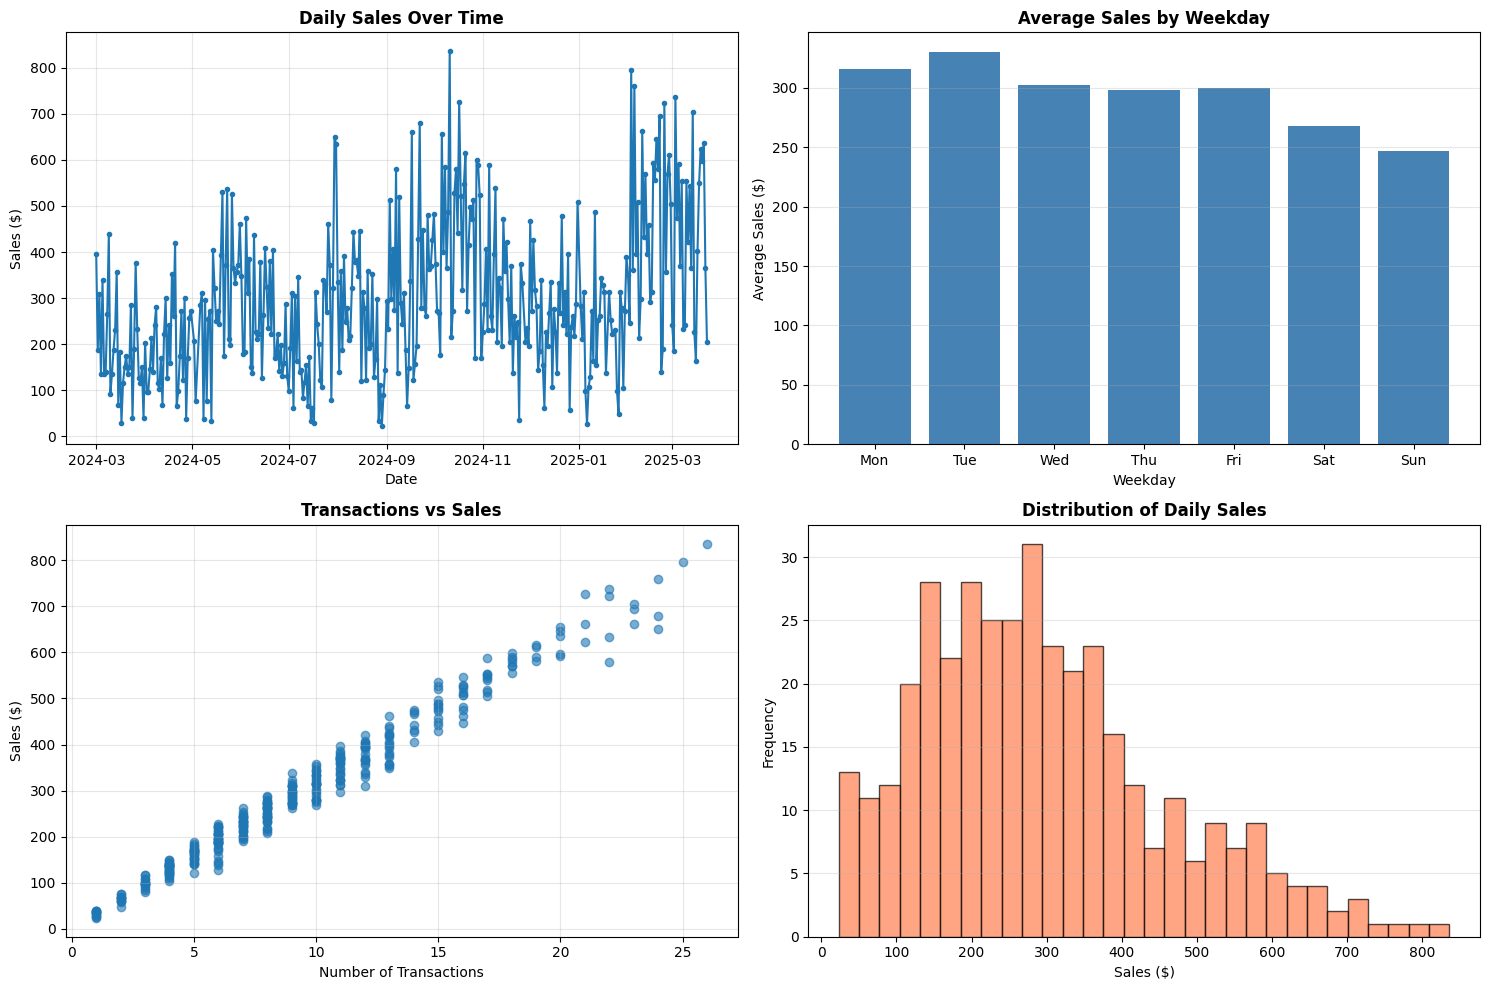


Sales statistics by weekday:
Weekday
Mon    315.692727
Tue    330.334182
Wed    302.893462
Thu    297.988889
Fri    300.047500
Sat    267.882182
Sun    246.964074
Name: money, dtype: float64


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily sales over time
axes[0, 0].plot(daily_data.index, daily_data['money'], marker='o', linestyle='-', markersize=3)
axes[0, 0].set_title('Daily Sales Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales ($)')
axes[0, 0].grid(True, alpha=0.3)

# Sales by weekday
weekday_sales = daily_data.groupby('Weekday')['money'].mean().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 1].bar(weekday_sales.index, weekday_sales.values, color='steelblue')
axes[0, 1].set_title('Average Sales by Weekday', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Weekday')
axes[0, 1].set_ylabel('Average Sales ($)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Number of transactions vs Sales
axes[1, 0].scatter(daily_data['num_transactions'], daily_data['money'], alpha=0.6)
axes[1, 0].set_title('Transactions vs Sales', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Transactions')
axes[1, 0].set_ylabel('Sales ($)')
axes[1, 0].grid(True, alpha=0.3)

# Sales distribution
axes[1, 1].hist(daily_data['money'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Daily Sales', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sales ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nSales statistics by weekday:")
print(weekday_sales)


#**Features Selection**


In [10]:
# Select features for modeling
feature_cols = [
    'Weekdaysort', 'Monthsort', 'num_transactions',
    'pct_afternoon', 'pct_morning', 'pct_night',
    'avg_transaction', 'sales_7day_avg', 'transactions_7day_avg',
    'weekday_historical_avg'
]

# Add coffee type percentages
coffee_pct_cols = [col for col in daily_data.columns if col.startswith('pct_') and 'coffee' in col]
feature_cols.extend(coffee_pct_cols)

# Add payment type percentages
payment_pct_cols = [col for col in daily_data.columns if col.startswith('pct_') and ('card' in col or 'cash' in col)]
feature_cols.extend(payment_pct_cols)

# Remove any features that might not exist
feature_cols = [col for col in feature_cols if col in daily_data.columns]

print(f"Selected features ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# Prepare X and y
X = daily_data[feature_cols].copy()
y = daily_data['money'].copy()

# Handle any remaining NaN values
X = X.fillna(X.mean())

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nMissing values in features: {X.isnull().sum().sum()}")

Selected features (11):
  1. Weekdaysort
  2. Monthsort
  3. num_transactions
  4. pct_afternoon
  5. pct_morning
  6. pct_night
  7. avg_transaction
  8. sales_7day_avg
  9. transactions_7day_avg
  10. weekday_historical_avg
  11. pct_card

Feature matrix shape: (381, 11)
Target variable shape: (381,)

Missing values in features: 0


#**Models initialization: Regressions, RF, Gradient Boosting**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [12]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # Use time-based split
)

print(f"Training set: {X_train.shape[0]} days")
print(f"Testing set: {X_test.shape[0]} days")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 304 days
Testing set: 77 days


In [13]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'predictions': y_test_pred
    }

    print(f"  Train RMSE: ${train_rmse:.2f}")
    print(f"  Test RMSE: ${test_rmse:.2f}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test MAE: ${test_mae:.2f}")


Training Linear Regression...
  Train RMSE: $12.03
  Test RMSE: $11.19
  Train R²: 0.9933
  Test R²: 0.9966
  Test MAE: $8.45

Training Ridge Regression...
  Train RMSE: $12.13
  Test RMSE: $11.40
  Train R²: 0.9932
  Test R²: 0.9965
  Test MAE: $8.72

Training Lasso Regression...
  Train RMSE: $13.70
  Test RMSE: $11.39
  Train R²: 0.9914
  Test R²: 0.9965
  Test MAE: $8.54

Training Random Forest...
  Train RMSE: $6.51
  Test RMSE: $27.44
  Train R²: 0.9981
  Test R²: 0.9795
  Test MAE: $14.51

Training Gradient Boosting...
  Train RMSE: $0.39
  Test RMSE: $23.88
  Train R²: 1.0000
  Test R²: 0.9845
  Test MAE: $11.18




8. Model Comparison
--------------------------------------------------------------------------------
            Model  Test RMSE  Test R²  Test MAE
Linear Regression  11.194195 0.996596  8.445965
 Ridge Regression  11.402715 0.996468  8.720626
 Lasso Regression  11.391797 0.996475  8.537586
    Random Forest  27.443984 0.979540 14.514148
Gradient Boosting  23.884729 0.984503 11.183224

Best Model: Linear Regression (R² = 0.9966)


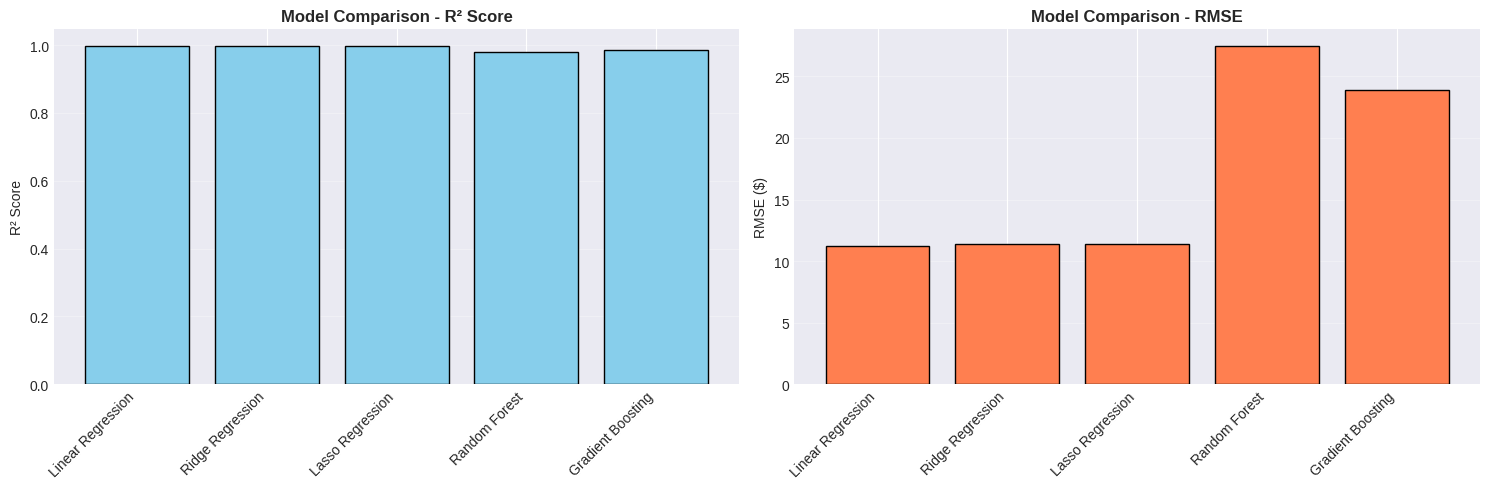

In [14]:
print("\n\n8. Model Comparison")
print("-" * 80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()]
})

print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name} (R² = {comparison_df['Test R²'].max():.4f})")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of R² scores
axes[0].bar(comparison_df['Model'], comparison_df['Test R²'], color='skyblue', edgecolor='black')
axes[0].set_title('Model Comparison - R² Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# Bar plot of RMSE
axes[1].bar(comparison_df['Model'], comparison_df['Test RMSE'], color='coral', edgecolor='black')
axes[1].set_title('Model Comparison - RMSE', fontsize=12, fontweight='bold')
axes[1].set_ylabel('RMSE ($)')
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#**Predictions calculation**


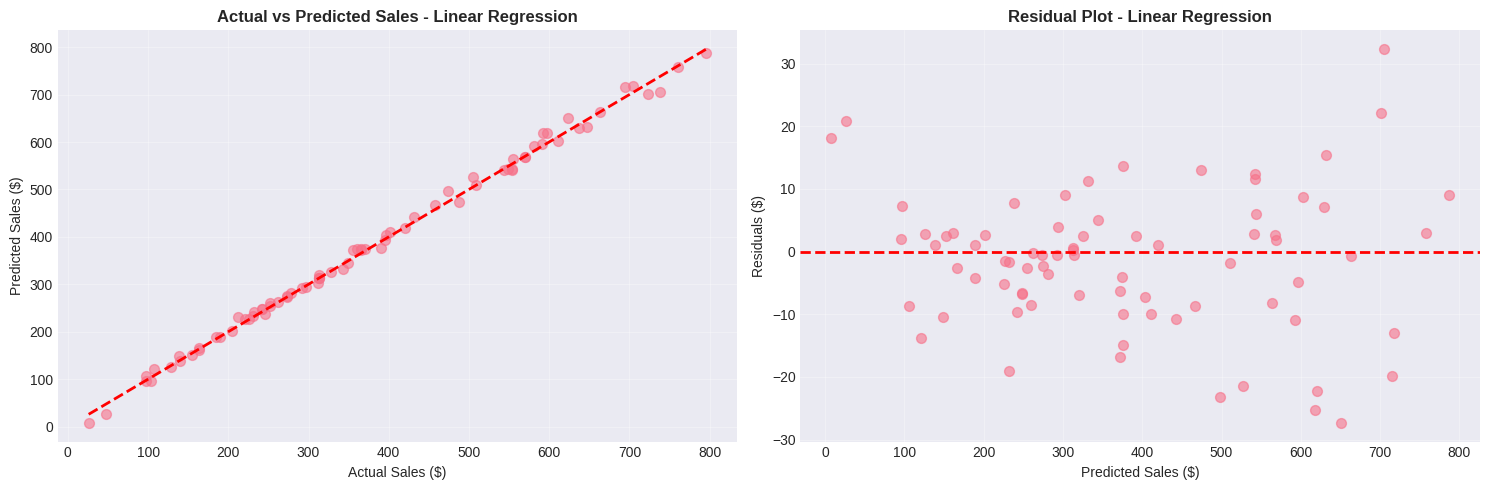

In [15]:
# Actual vs Predicted + Residuals
best_predictions = results[best_model_name]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Actual vs Predicted
axes[0].scatter(y_test, best_predictions, alpha=0.6, s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f'Actual vs Predicted Sales - {best_model_name}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Actual Sales ($)')
axes[0].set_ylabel('Predicted Sales ($)')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.6, s=50)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_title(f'Residual Plot - {best_model_name}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Sales ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()





#**Prediction as a function**

In [16]:
def predict_daily_sales(weekday, month, time_distribution, coffee_distribution,
                       num_transactions, payment_distribution=None):
    """
    Predict daily sales for a given day configuration.

    Parameters:
    -----------
    weekday : str or int
        Day of week ('Mon', 'Tue', etc. or 1-7)
    month : str or int
        Month name or number (1-12)
    time_distribution : dict
        Distribution of orders by time {'morning': 0.4, 'afternoon': 0.4, 'night': 0.2}
    coffee_distribution : dict
        Distribution of orders by coffee type
    num_transactions : int
        Expected number of transactions
    payment_distribution : dict, optional
        Distribution by payment type {'card': 0.6, 'cash': 0.4}

    Returns:
    --------
    float : Predicted sales amount
    """

    # Convert weekday to number if string
    weekday_map = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
    if isinstance(weekday, str):
        weekdaysort = weekday_map.get(weekday, 1)
    else:
        weekdaysort = weekday

    # Convert month to number if string
    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    if isinstance(month, str):
        monthsort = month_map.get(month, 1)
    else:
        monthsort = month

    # Create feature vector
    features = {}
    features['Weekdaysort'] = weekdaysort
    features['Monthsort'] = monthsort
    features['num_transactions'] = num_transactions

    # Time distribution
    features['pct_morning'] = time_distribution.get('morning', 0.33)
    features['pct_afternoon'] = time_distribution.get('afternoon', 0.33)
    features['pct_night'] = time_distribution.get('night', 0.34)

    # Use historical averages for rolling features
    features['sales_7day_avg'] = daily_data['sales_7day_avg'].mean()
    features['transactions_7day_avg'] = daily_data['transactions_7day_avg'].mean()
    features['weekday_historical_avg'] = daily_data.groupby('Weekdaysort')['money'].mean().get(weekdaysort, daily_data['money'].mean())

    # Estimate average transaction from historical data
    features['avg_transaction'] = daily_data['avg_transaction'].mean()

    # Coffee distribution (use averages if not provided)
    for col in coffee_pct_cols:
        coffee_name = col.replace('pct_', '').replace('_', ' ')
        features[col] = coffee_distribution.get(coffee_name, daily_data[col].mean() if col in daily_data.columns else 0)

    # Payment distribution
    if payment_distribution:
        for col in payment_pct_cols:
            payment_type = col.replace('pct_', '')
            features[col] = payment_distribution.get(payment_type, 0.5)
    else:
        for col in payment_pct_cols:
            features[col] = daily_data[col].mean() if col in daily_data.columns else 0.5

    # Create DataFrame with correct column order
    feature_df = pd.DataFrame([features])[feature_cols]

    # Scale features
    feature_scaled = scaler.transform(feature_df)

    # Make prediction
    prediction = best_model.predict(feature_scaled)[0]

    return prediction

In [17]:
# Example 1: Typical Monday
print("\nExample 1: Typical Monday")
time_dist = {'morning': 0.45, 'afternoon': 0.35, 'night': 0.20}
coffee_dist = {}  # Will use averages
transactions_level = daily_data[daily_data['Weekday']=='Mon']['num_transactions'].mean()
predicted_sales_mon = predict_daily_sales(
    weekday='Mon',
    month=1,
    time_distribution=time_dist,
    coffee_distribution=coffee_dist,
    num_transactions=transactions_level
)
print(f"  Predicted Sales: ${predicted_sales_mon:.2f}")

# Example 2: Busy Saturday
print("\nExample 2: Busy Saturday")
time_dist = {'morning': 0.40, 'afternoon': 0.40, 'night': 0.20}
transactions_level = daily_data[daily_data['Weekday']=='Sat']['num_transactions'].mean()
predicted_sales_sat = predict_daily_sales(
    weekday='Sat',
    month=6,
    time_distribution=time_dist,
    coffee_distribution=coffee_dist,
    num_transactions=transactions_level
)
print(f"  Predicted Sales: ${predicted_sales_sat:.2f}")

# Example 3: Quiet Sunday
print("\nExample 3: Quiet Sunday")
time_dist = {'morning': 0.50, 'afternoon': 0.30, 'night': 0.20}
transactions_level = daily_data[daily_data['Weekday']=='Sun']['num_transactions'].mean()
predicted_sales_sun = predict_daily_sales(
    weekday='Sun',
    month=12,
    time_distribution=time_dist,
    coffee_distribution=coffee_dist,
    num_transactions=transactions_level
)
print(f"  Predicted Sales: ${predicted_sales_sun:.2f}")



Example 1: Typical Monday
  Predicted Sales: $317.22

Example 2: Busy Saturday
  Predicted Sales: $271.63

Example 3: Quiet Sunday
  Predicted Sales: $245.35


In [18]:
# Define typical time-of-day distribution
typical_time_dist = {'morning': 0.4, 'afternoon': 0.4, 'night': 0.2}

# Coffee distribution left empty to use historical averages
coffee_dist = {}

# Prepare weekday list
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Prepare month (just use January as example)
month = 1

# Store results
weekly_predictions = []

for day in weekdays:
    # Use average number of transactions for that weekday
    transactions_level = daily_data[daily_data['Weekday'] == day]['num_transactions'].mean()

    predicted_sales = predict_daily_sales(
        weekday=day,
        month=month,
        time_distribution=typical_time_dist,
        coffee_distribution=coffee_dist,
        num_transactions=transactions_level
    )

    weekly_predictions.append({
        'Weekday': day,
        'Predicted_Sales': round(predicted_sales, 2)
    })

# Convert to DataFrame for nice display
weekly_sales_df = pd.DataFrame(weekly_predictions)
print(weekly_sales_df)


  Weekday  Predicted_Sales
0     Mon           317.55
1     Tue           333.87
2     Wed           307.59
3     Thu           301.66
4     Fri           303.17
5     Sat           271.34
6     Sun           245.37


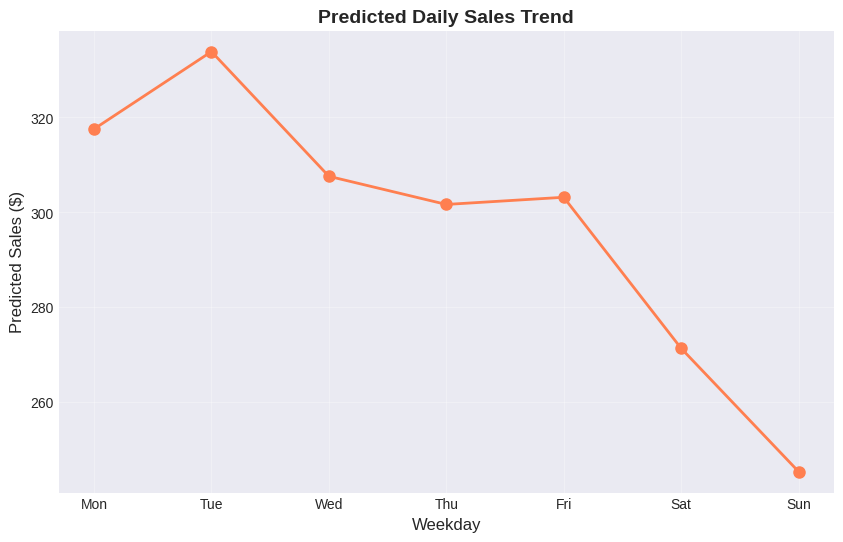

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Weekly predictions DataFrame
weekly_predictions = pd.DataFrame({
    'Weekday': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    'Predicted_Sales': [317.55, 333.87, 307.59, 301.66, 303.17, 271.34, 245.37]
})

# Plot
plt.figure(figsize=(10,6))
plt.plot(weekly_predictions['Weekday'], weekly_predictions['Predicted_Sales'], marker='o', linestyle='-', color='coral', linewidth=2, markersize=8)
plt.title('Predicted Daily Sales Trend', fontsize=14, fontweight='bold')
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Predicted Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(weekly_predictions['Weekday'])
plt.show()
